In [1]:
import numpy as np
import pandas as pd

# 時系列データを作成
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', periods=100, freq='D')
data = np.cumsum(np.random.randn(100)) + 100  # ランダムウォーク

df = pd.DataFrame({'ds': date_range, 'y': data})


c:\Users\sadan\OneDrive\Desktop\code\time_series_analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:31:58 - cmdstanpy - INFO - Chain [1] start processing
20:31:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sadan\OneDrive\Desktop\code\time_series_analysis\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\sadan\OneDrive\Desktop\code\time_series_analysis\venv\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydate

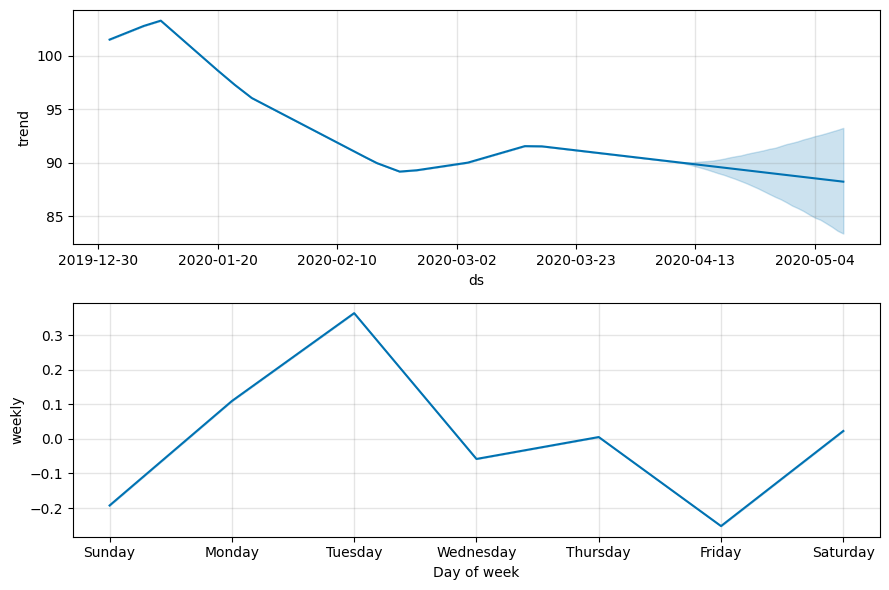

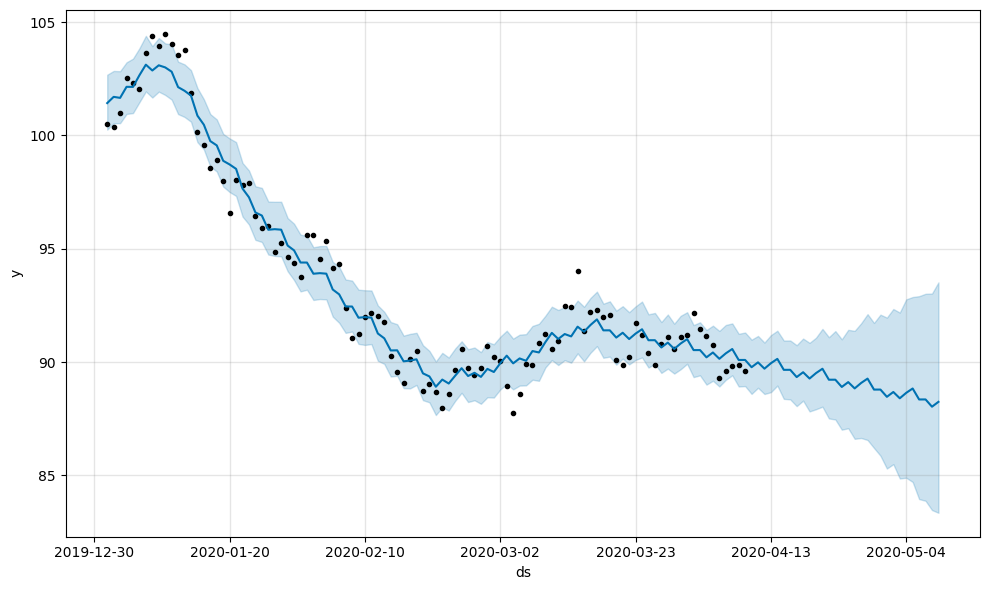

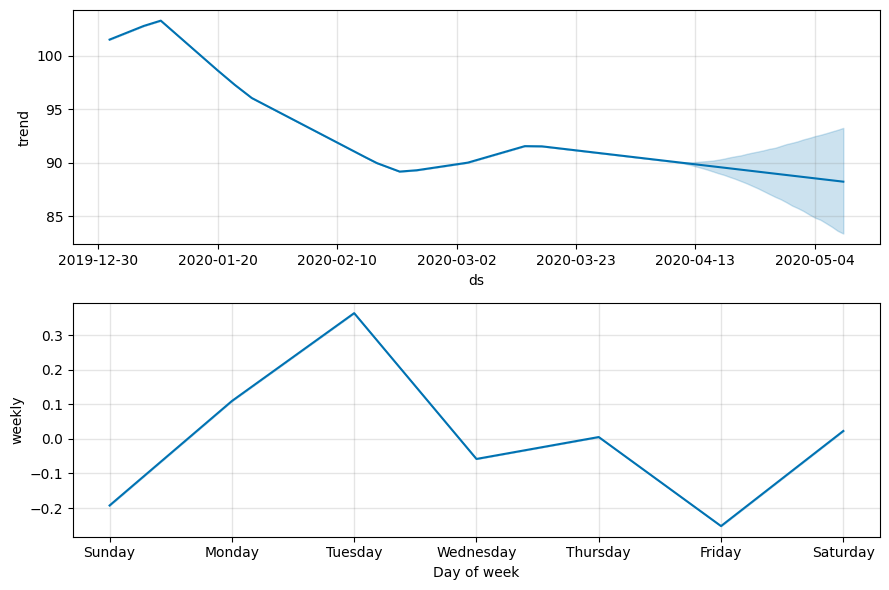

In [2]:
from prophet import Prophet

# モデルの初期化とフィッティング
model = Prophet()
model.fit(df)

# 未来の日付を生成
future = model.make_future_dataframe(periods=30)

# 予測
forecast = model.predict(future)

# 結果の表示
model.plot(forecast)
model.plot_components(forecast)


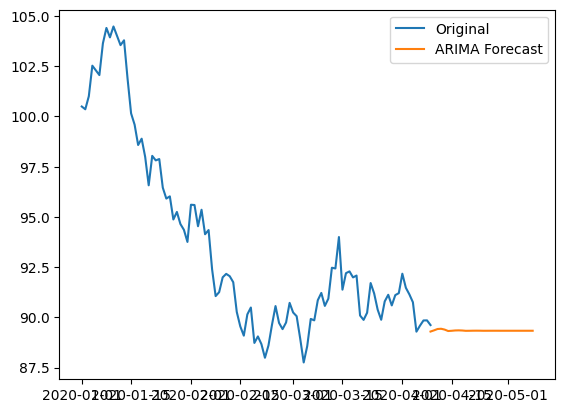

In [3]:
from statsmodels.tsa.arima.model import ARIMA

# モデルのフィッティング
model_arima = ARIMA(df['y'], order=(5,1,0))  # ARIMA(p,d,q)モデル
arima_result = model_arima.fit()

# 予測
forecast_arima = arima_result.forecast(steps=30)

# 結果の表示
import matplotlib.pyplot as plt
plt.plot(df['ds'], df['y'], label='Original')
plt.plot(pd.date_range(start=df['ds'].iloc[-1], periods=30, freq='D'), forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.show()
